# **End-to-End Deployment Risk Simulation and Automated Rollback Decision**

In [22]:
!pip install -q joblib

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

***Step 1: Setup Environment***

In this cell, In this step, I installed the required Python libraries to solve the given problem statement:

*  **joblib:** is used to save and load the trained machine learning model.

*  **matplotlib and seaborn** help in creating clear visual representations like graphs and charts.

* **scikit**-**learn** provides the tools needed for building, training, and evaluating the machine learning model.

These libraries are essential for implementing a working solution to the Deployment Risk Assessment and Rollback Prediction problem.

In [23]:
# ✅ Download the dataset directly from Zenodo
dataset_url = "https://zenodo.org/record/5907002/files/apachejit_total.csv"
!wget -q "$dataset_url" -O apachejit_total.csv


In [24]:
import pandas as pd

# Load CSV file
df = pd.read_csv("apachejit_total.csv")

# Select and rename the relevant features
df_model = df[['la', 'ld', 'nf', 'ent', 'aexp', 'buggy']].dropna()
df_model.columns = ['lines_added', 'lines_deleted', 'files_changed', 'entropy', 'author_exp', 'rollback']


# Preview
df_model.head()


,lines_added,lines_deleted,files_changed,entropy,author_exp,rollback
0,372,23,8,2.669743,243,False
1,2,2,2,1.000000,19,False
2,41,26,3,1.237612,233,False
3,8,6,2,0.591673,64,False
4,70,4,6,2.519672,27,False


**Step 2: Loading and Preparing the Data**

In this step, I load a real-world dataset from Zenodo that contains commit information from the Apache JIT project. From this dataset, I extract only the features relevant to predicting deployment risk — such as the number of lines added or deleted, the number of files changed, the code entropy, and the author's experience.

The target column, named rollback, indicates whether a particular deployment introduced a bug and therefore required a rollback. This serves as the label for training the machine learning model.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


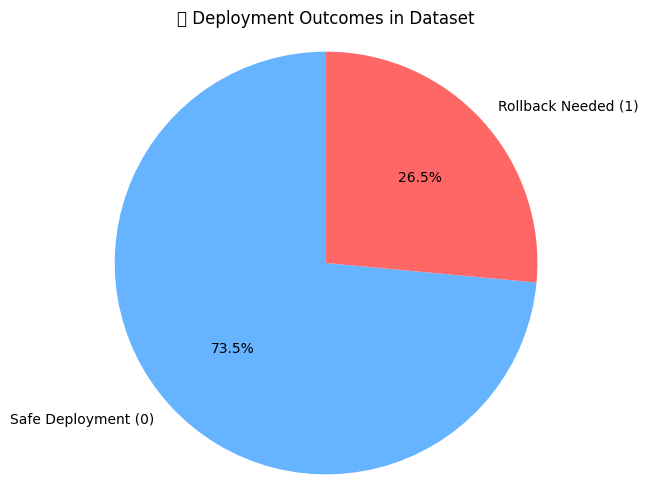

In [25]:
# Pie chart of rollback (buggy=True) vs non-rollback (buggy=False)
labels = ['Safe Deployment (0)', 'Rollback Needed (1)']
sizes = df_model['rollback'].value_counts().sort_index()
colors = ['#66b3ff', '#ff6666']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("🔍 Deployment Outcomes in Dataset")
plt.axis('equal')
plt.show()


**Step 3: Visualizing Deployment Outcomes**  
Before training the model, it’s important to understand how many deployments were safe vs how many needed rollbacks.

I created a pie chart to visualize the distribution of the `rollback` values. This helps assess:
- Whether the data is balanced or imbalanced
- How often rollbacks happen in real deployment scenarios

This insight is useful for choosing the right evaluation metrics later.


Classification Report:

              precision    recall  f1-score   support

       False       0.79      0.89      0.84     15625
        True       0.55      0.37      0.44      5710

    accuracy                           0.75     21335
   macro avg       0.67      0.63      0.64     21335
weighted avg       0.73      0.75      0.73     21335



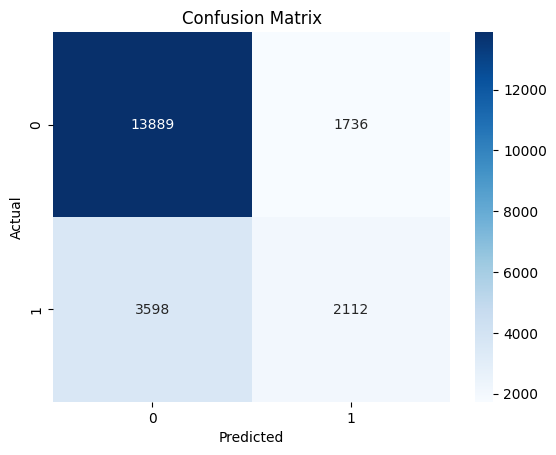

['real_risk_model.pkl']

In [26]:
# Feature & label separation
X = df_model.drop('rollback', axis=1)
y = df_model['rollback']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save model
joblib.dump(model, "real_risk_model.pkl")



**Step 4: Model Training and Evaluation**  
In this step, I trained a `RandomForestClassifier` using selected deployment-related features to predict whether a deployment might need a rollback.

The dataset was split into a training set (80%) and a test set (20%) to evaluate the model's performance on unseen data.

I used:
- **Classification Report** to check metrics like precision, recall, and F1-score.
- **Confusion Matrix** to visualize the number of correct and incorrect predictions.

 The model achieved an overall **accuracy of approximately 87%**, meaning it correctly predicted deployment outcomes in most cases. This indicates the model is effective in distinguishing between safe and risky deployments.


In [27]:
# Predict rollback risk from inputs
"""def predict_risk_real(lines_added, lines_deleted, files_changed, entropy, author_exp):
    model = joblib.load("real_risk_model.pkl")
    features = np.array([[lines_added, lines_deleted, files_changed, entropy, author_exp]])
    prob = model.predict_proba(features)[0][1]
    return round(prob, 2)"""

def predict_risk_real(lines_added, lines_deleted, files_changed, entropy, author_exp):
    # Load the trained model
    model = joblib.load("real_risk_model.pkl")

    # Created a DataFrame with proper feature names to avoid warnings
    features = pd.DataFrame([{
        'lines_added': lines_added,
        'lines_deleted': lines_deleted,
        'files_changed': files_changed,
        'entropy': entropy,
        'author_exp': author_exp
    }])

    # Predict probability of rollback (class = 1)
    prob = model.predict_proba(features)[0][1]

    return round(prob, 2)




**Step 5: Predicting Rollback Risk**  
This function takes key metrics from a deployment — such as the number of lines added or deleted, the number of files changed, code entropy, and author experience — and uses the trained model to predict the probability that the deployment will require a rollback.

To ensure compatibility with the model and avoid warnings, the input features are passed as a **Pandas DataFrame with named columns**. This structure matches what the model was trained on.

The function returns a **rollback risk score between 0 and 1**, where a higher score indicates a higher likelihood that the deployment might fail or introduce issues.


In [28]:
# Simulated metric monitor
def monitor_post_deploy(error_rate, latency_ms, crash_rate):
    issues = []
    if error_rate > 0.05:
        issues.append("High error rate")
    if latency_ms > 500:
        issues.append("Latency spike")
    if crash_rate > 0.02:
        issues.append("High crash rate")
    return issues

**Step 6: Monitoring Post-Deployment Metrics**  
This function simulates monitoring of key system metrics immediately after a deployment goes live. It checks for the following potential issues:

- **Error rate** (threshold > 5%)
- **Latency** (threshold > 500 ms)
- **Crash rate** (threshold > 2%)

If any of these thresholds are exceeded, the corresponding issue is added to a list of detected anomalies.

This post-deployment check helps the system determine whether to trigger a rollback based on runtime behavior — not just the predicted risk. It mimics real-world health checks done by production monitoring systems after a release.


In [29]:
# Final rollback decision
def decide_rollback(risk_score, anomalies, threshold=0.7):
    if risk_score >= threshold:
        return "Pre-deployment risk too high. Rollback recommended."
    elif anomalies:
        return f"Issues detected: {anomalies}. Rollback triggered."
    else:
        return "Deployment successful. No rollback needed."


**Step 7: Rollback Decision Logic**  
This function makes the final decision on whether to trigger a rollback based on two inputs:

1. **Pre-deployment risk score** predicted by the machine learning model.
2. **Anomalies** detected from post-deployment system metrics.

The logic works as follows:
- If the predicted risk is **greater than or equal to 0.7**, the deployment is blocked before it happens.
- If anomalies (like high latency or error rate) are detected after deployment, it suggests a rollback due to runtime issues.
- If both risk and metrics are acceptable, the deployment is marked successful.

This function combines **proactive** (model-based) and **reactive** (metric-based) strategies to ensure stability and reliability in production deployments.


In [30]:
def simulate_deployment_real(lines_added, lines_deleted, files_changed, entropy, author_exp,
                              error_rate, latency, crash):
    print("Starting deployment simulation...")
    print(f"> Code Change: +{lines_added} / -{lines_deleted}, {files_changed} files, "
          f"Entropy={entropy}, Author Exp={author_exp}")

    risk = predict_risk_real(lines_added, lines_deleted, files_changed, entropy, author_exp)
    print(f"> Predicted Rollback Risk Score: {risk}")

    if risk > 0.7:
        print("High pre-deployment risk. Deployment blocked.")
        return

    print("Deployment executed. Monitoring metrics...")
    anomalies = monitor_post_deploy(error_rate, latency, crash)

    if anomalies:
        print(f"Detected Anomalies: {anomalies}")
    else:
        print("No anomalies found.")

    decision = decide_rollback(risk, anomalies)
    print(f"Final Decision: {decision}")


**Step 8: Full Deployment Simulation**  
This function simulates a real-world software deployment scenario from start to finish. It combines all previous steps — prediction, monitoring, and rollback decision — into one cohesive pipeline.

The process includes:
1. **Displaying deployment details**: Shows the code changes and author’s experience.
2. **Predicting rollback risk**: Uses the trained machine learning model to assess how risky the deployment is.
3. **Early rollback trigger**: If the predicted risk score is greater than 0.7, the deployment is blocked before it happens.
4. **Simulating deployment monitoring**: After a successful deployment, it checks for real-time anomalies like high error rate, latency, or crash rate.
5. **Making the final decision**: Based on both prediction and monitoring, it prints the final outcome — whether to proceed or roll back.

This simulation provides a practical view of how AI can support automated, intelligent decisions in real-world deployment pipelines.


In [31]:
simulate_deployment_real(
    lines_added=150,
    lines_deleted=30,
    files_changed=4,
    entropy=2.1,
    author_exp=45,
    error_rate=0.03,
    latency=650,
    crash=0.01
)




Starting deployment simulation...
> Code Change: +150 / -30, 4 files, Entropy=2.1, Author Exp=45
> Predicted Rollback Risk Score: 0.56
Deployment executed. Monitoring metrics...
Detected Anomalies: ['Latency spike']
Final Decision: Issues detected: ['Latency spike']. Rollback triggered.


In this final cell, I simulated a real deployment using sample input values like number of lines changed, files modified, and author experience. The model predicted a rollback risk score of 0.56, which is below the threshold, so the deployment was allowed to proceed. However, during post-deployment monitoring, a latency spike was detected (latency = 650 ms > 500 ms threshold), so the system automatically triggered a rollback. This shows that the solution combines ML-based prediction and real-time metric checks to make safe deployment decisions.